In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

class QLearningAgent:
    """Q-Learning Agent for solving the CliffWalk environment"""
    
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Initialize Q-Learning Agent
        
        Args:
            n_states: Number of states in the environment
            n_actions: Number of actions available
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            epsilon: Initial exploration rate
            epsilon_decay: Decay rate for epsilon
            epsilon_min: Minimum epsilon value
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((n_states, n_actions))
        
        # For tracking learning progress
        self.episode_rewards = []
        self.episode_lengths = []
        
    def get_action(self, state, training=True):
        """
        Choose action using epsilon-greedy policy
        
        Args:
            state: Current state
            training: Whether in training mode (affects exploration)
        
        Returns:
            action: Selected action
        """
        if training and np.random.random() < self.epsilon:
            # Explore: choose random action
            return np.random.randint(self.n_actions)
        else:
            # Exploit: choose action with highest Q-value
            return np.argmax(self.q_table[state])
    
    def update_q_table(self, state, action, reward, next_state, done):
        """
        Update Q-table using Q-learning formula
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode is finished
        """
        # Q-learning update formula
        current_q = self.q_table[state, action]
        
        if done:
            # Terminal state has no future rewards
            max_next_q = 0
        else:
            # Use the maximum Q-value of next state
            max_next_q = np.max(self.q_table[next_state])
        
        # Q(s,a) = Q(s,a) + α[r + γ*max(Q(s',a')) - Q(s,a)]
        new_q = current_q + self.lr * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state, action] = new_q
    
    def decay_epsilon(self):
        """Decay epsilon after each episode"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def train(self, env, n_episodes=1000, max_steps_per_episode=200):
        """
        Train the Q-learning agent
        
        Args:
            env: Gymnasium environment
            n_episodes: Number of training episodes
            max_steps_per_episode: Maximum steps per episode
        
        Returns:
            training_history: Dictionary with training metrics
        """
        print(f"Training Q-Learning agent for {n_episodes} episodes...")
        
        for episode in range(n_episodes):
            state, _ = env.reset()
            total_reward = 0
            steps = 0
            
            for step in range(max_steps_per_episode):
                # Choose action
                action = self.get_action(state, training=True)
                
                # Take action
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                # Update Q-table
                self.update_q_table(state, action, reward, next_state, done)
                
                # Update state and tracking variables
                state = next_state
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            # Decay epsilon
            self.decay_epsilon()
            
            # Track episode metrics
            self.episode_rewards.append(total_reward)
            self.episode_lengths.append(steps)
            
            # Print progress
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_length = np.mean(self.episode_lengths[-100:])
                print(f"Episode {episode + 1}/{n_episodes} - "
                      f"Avg Reward: {avg_reward:.2f}, "
                      f"Avg Length: {avg_length:.2f}, "
                      f"Epsilon: {self.epsilon:.3f}")
        
        print("Training completed!")
        
        return {
            'episode_rewards': self.episode_rewards,
            'episode_lengths': self.episode_lengths
        }
    
    def test(self, env, n_episodes=10, render=False):
        """
        Test the trained agent
        
        Args:
            env: Gymnasium environment
            n_episodes: Number of test episodes
            render: Whether to render the environment
        
        Returns:
            test_results: Dictionary with test metrics
        """
        print(f"Testing agent for {n_episodes} episodes...")
        
        test_rewards = []
        test_lengths = []
        success_count = 0
        
        for episode in range(n_episodes):
            state, _ = env.reset()
            total_reward = 0
            steps = 0
            
            while True:
                if render:
                    env.render()
                
                # Choose action (no exploration)
                action = self.get_action(state, training=False)
                
                # Take action
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                state = next_state
                total_reward += reward
                steps += 1
                
                if done:
                    if terminated and reward > -100:  # Reached goal successfully
                        success_count += 1
                    break
            
            test_rewards.append(total_reward)
            test_lengths.append(steps)
            
            print(f"Test Episode {episode + 1}: Reward = {total_reward}, Steps = {steps}")
        
        avg_reward = np.mean(test_rewards)
        avg_length = np.mean(test_lengths)
        success_rate = success_count / n_episodes
        
        print(f"\nTest Results:")
        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Average Episode Length: {avg_length:.2f}")
        print(f"Success Rate: {success_rate:.2%}")
        
        return {
            'test_rewards': test_rewards,
            'test_lengths': test_lengths,
            'success_rate': success_rate
        }

In [2]:
# Create the CliffWalk environment
env = gym.make('CliffWalking-v0')

# Get environment information
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"CliffWalk Environment:")
print(f"Number of states: {n_states}")
print(f"Number of actions: {n_actions}")
print(f"Action meanings: {['UP', 'RIGHT', 'DOWN', 'LEFT']}")

# Display the environment layout
print("\nEnvironment Layout:")
print("The agent starts at the bottom-left (S) and needs to reach the goal at bottom-right (G)")
print("The cliff is represented by 'C' - falling off results in a large negative reward")
print("Safe path is along the top or sides")

# Initialize Q-Learning agent
agent = QLearningAgent(
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=0.1,      # Alpha
    discount_factor=0.95,   # Gamma
    epsilon=1.0,            # Initial exploration rate
    epsilon_decay=0.995,    # Decay rate
    epsilon_min=0.01        # Minimum exploration rate
)

print(f"\nQ-Learning Agent initialized with:")
print(f"Learning rate (α): {agent.lr}")
print(f"Discount factor (γ): {agent.gamma}")
print(f"Initial epsilon (ε): {agent.epsilon}")
print(f"Q-table shape: {agent.q_table.shape}")

CliffWalk Environment:
Number of states: 48
Number of actions: 4
Action meanings: ['UP', 'RIGHT', 'DOWN', 'LEFT']

Environment Layout:
The agent starts at the bottom-left (S) and needs to reach the goal at bottom-right (G)
The cliff is represented by 'C' - falling off results in a large negative reward
Safe path is along the top or sides

Q-Learning Agent initialized with:
Learning rate (α): 0.1
Discount factor (γ): 0.95
Initial epsilon (ε): 1.0
Q-table shape: (48, 4)


In [3]:
# Train the Q-Learning agent
training_history = agent.train(env, n_episodes=1000, max_steps_per_episode=200)

print(f"\nTraining Summary:")
print(f"Final epsilon: {agent.epsilon:.3f}")
print(f"Last 100 episodes average reward: {np.mean(agent.episode_rewards[-100:]):.2f}")
print(f"Last 100 episodes average length: {np.mean(agent.episode_lengths[-100:]):.2f}")

Training Q-Learning agent for 1000 episodes...
Episode 100/1000 - Avg Reward: -1347.50, Avg Length: 160.49, Epsilon: 0.606
Episode 200/1000 - Avg Reward: -398.81, Avg Length: 61.22, Epsilon: 0.367
Episode 300/1000 - Avg Reward: -162.15, Avg Length: 30.48, Epsilon: 0.222
Episode 400/1000 - Avg Reward: -95.30, Avg Length: 22.04, Epsilon: 0.135
Episode 500/1000 - Avg Reward: -65.31, Avg Length: 18.78, Epsilon: 0.082
Episode 600/1000 - Avg Reward: -35.52, Avg Length: 15.72, Epsilon: 0.049
Episode 700/1000 - Avg Reward: -34.69, Avg Length: 14.89, Epsilon: 0.030
Episode 800/1000 - Avg Reward: -14.38, Avg Length: 13.39, Epsilon: 0.018
Episode 900/1000 - Avg Reward: -14.20, Avg Length: 13.21, Epsilon: 0.011
Episode 1000/1000 - Avg Reward: -15.28, Avg Length: 13.30, Epsilon: 0.010
Training completed!

Training Summary:
Final epsilon: 0.010
Last 100 episodes average reward: -15.28
Last 100 episodes average length: 13.30


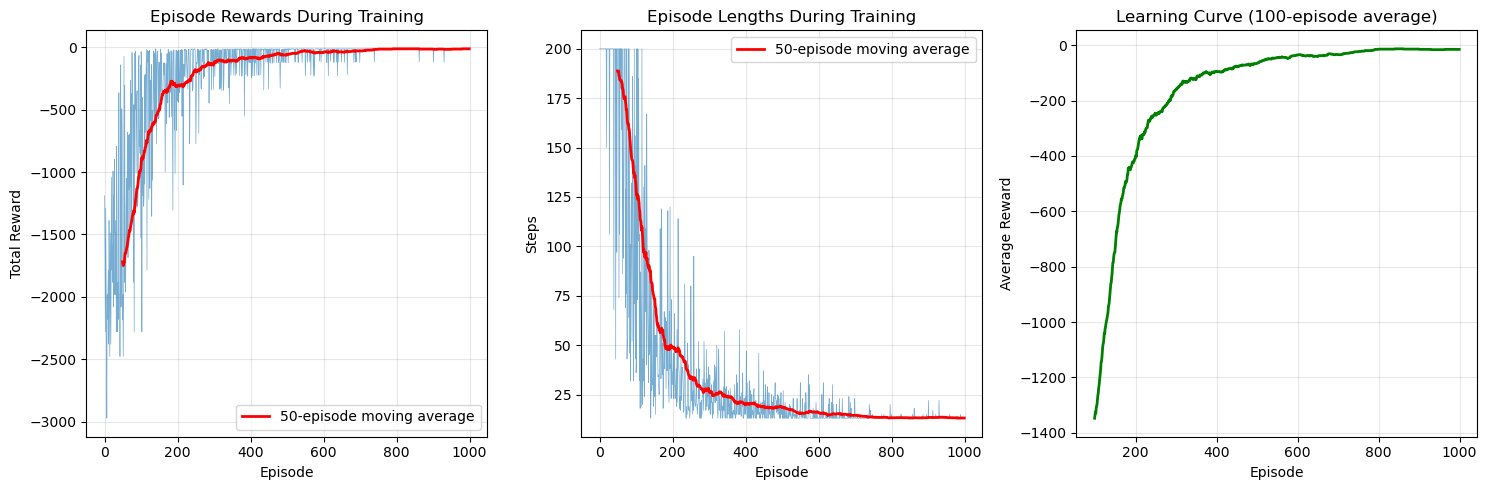

Training Statistics:
Total episodes: 1000
Best episode reward: -13
Worst episode reward: -2972
Average reward (all episodes): -218.31
Average reward (last 100 episodes): -15.28
Standard deviation (last 100 episodes): 15.11


In [4]:
# Visualize training progress
plt.figure(figsize=(15, 5))

# Plot 1: Episode rewards over time
plt.subplot(1, 3, 1)
plt.plot(agent.episode_rewards, alpha=0.6, linewidth=0.5)
# Add moving average for better visualization
window_size = 50
if len(agent.episode_rewards) >= window_size:
    moving_avg = np.convolve(agent.episode_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(agent.episode_rewards)), moving_avg, 'r-', linewidth=2, label=f'{window_size}-episode moving average')
    plt.legend()
plt.title('Episode Rewards During Training')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True, alpha=0.3)

# Plot 2: Episode lengths over time
plt.subplot(1, 3, 2)
plt.plot(agent.episode_lengths, alpha=0.6, linewidth=0.5)
# Add moving average
if len(agent.episode_lengths) >= window_size:
    moving_avg = np.convolve(agent.episode_lengths, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(agent.episode_lengths)), moving_avg, 'r-', linewidth=2, label=f'{window_size}-episode moving average')
    plt.legend()
plt.title('Episode Lengths During Training')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True, alpha=0.3)

# Plot 3: Learning curve (last 100 episodes average)
plt.subplot(1, 3, 3)
window = 100
if len(agent.episode_rewards) >= window:
    learning_curve = [np.mean(agent.episode_rewards[max(0, i-window):i+1]) 
                     for i in range(window-1, len(agent.episode_rewards))]
    plt.plot(range(window-1, len(agent.episode_rewards)), learning_curve, 'g-', linewidth=2)
    plt.title(f'Learning Curve ({window}-episode average)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Training Statistics:")
print(f"Total episodes: {len(agent.episode_rewards)}")
print(f"Best episode reward: {max(agent.episode_rewards)}")
print(f"Worst episode reward: {min(agent.episode_rewards)}")
print(f"Average reward (all episodes): {np.mean(agent.episode_rewards):.2f}")
print(f"Average reward (last 100 episodes): {np.mean(agent.episode_rewards[-100:]):.2f}")
print(f"Standard deviation (last 100 episodes): {np.std(agent.episode_rewards[-100:]):.2f}")

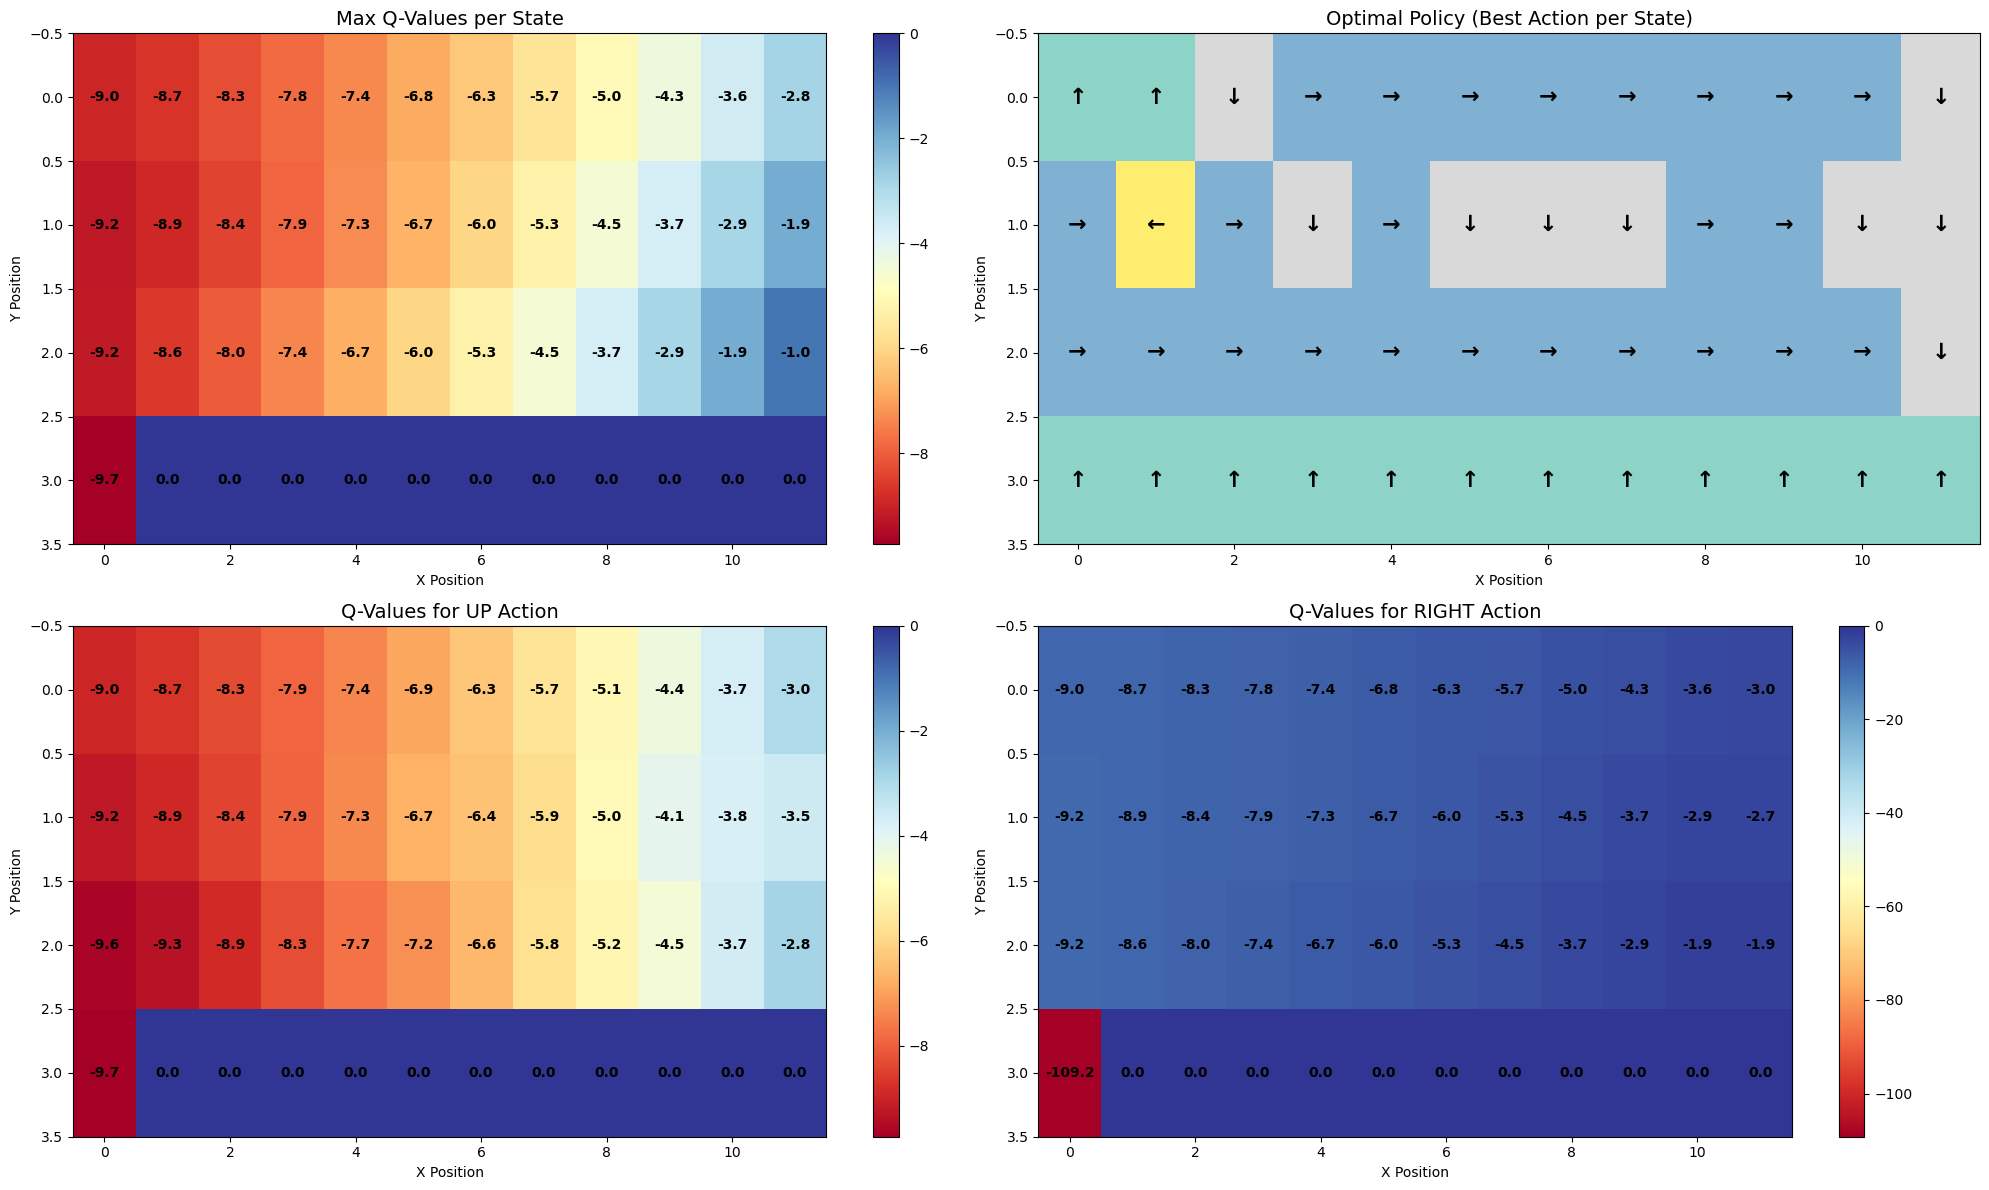

CliffWalk Environment Layout:
┌─────────────────────────────────────────────┐
│  S: Start position (bottom-left)           │
│  G: Goal position (bottom-right)           │
│  C: Cliff (immediate negative reward)      │
│  .: Safe positions                         │
└─────────────────────────────────────────────┘

Grid Layout (4x12):
  0  1  2  3  4  5  6  7  8  9 10 11
0 .  .  .  .  .  .  .  .  .  .  .  .
1 .  .  .  .  .  .  .  .  .  .  .  .
2 .  .  .  .  .  .  .  .  .  .  .  .
3 S  C  C  C  C  C  C  C  C  C  C  G


In [5]:
# Visualize the learned Q-table and policy
def visualize_qtable_and_policy(agent, env):
    """Visualize the Q-table values and optimal policy"""
    
    # CliffWalk environment is 4x12 grid
    grid_height = 4
    grid_width = 12
    
    # Reshape Q-table for visualization
    q_values = agent.q_table.reshape(grid_height, grid_width, -1)
    
    # Get optimal policy (best action for each state)
    policy = np.argmax(agent.q_table, axis=1).reshape(grid_height, grid_width)
    
    # Action symbols for visualization
    action_symbols = ['↑', '→', '↓', '←']  # UP, RIGHT, DOWN, LEFT
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Plot 1: Max Q-values for each state
    max_q_values = np.max(agent.q_table, axis=1).reshape(grid_height, grid_width)
    im1 = axes[0, 0].imshow(max_q_values, cmap='RdYlBu', aspect='auto')
    axes[0, 0].set_title('Max Q-Values per State', fontsize=14)
    
    # Add text annotations
    for i in range(grid_height):
        for j in range(grid_width):
            text = f'{max_q_values[i, j]:.1f}'
            axes[0, 0].text(j, i, text, ha='center', va='center', fontweight='bold')
    
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Plot 2: Optimal Policy
    im2 = axes[0, 1].imshow(policy, cmap='Set3', aspect='auto')
    axes[0, 1].set_title('Optimal Policy (Best Action per State)', fontsize=14)
    
    # Add action symbols
    for i in range(grid_height):
        for j in range(grid_width):
            symbol = action_symbols[policy[i, j]]
            axes[0, 1].text(j, i, symbol, ha='center', va='center', fontsize=16, fontweight='bold')
    
    axes[0, 1].set_xlabel('X Position')
    axes[0, 1].set_ylabel('Y Position')
    
    # Plot 3: Q-values for UP action
    up_q_values = q_values[:, :, 0]  # UP action
    im3 = axes[1, 0].imshow(up_q_values, cmap='RdYlBu', aspect='auto')
    axes[1, 0].set_title('Q-Values for UP Action', fontsize=14)
    
    for i in range(grid_height):
        for j in range(grid_width):
            text = f'{up_q_values[i, j]:.1f}'
            axes[1, 0].text(j, i, text, ha='center', va='center', fontweight='bold')
    
    axes[1, 0].set_xlabel('X Position')
    axes[1, 0].set_ylabel('Y Position')
    plt.colorbar(im3, ax=axes[1, 0])
    
    # Plot 4: Q-values for RIGHT action
    right_q_values = q_values[:, :, 1]  # RIGHT action
    im4 = axes[1, 1].imshow(right_q_values, cmap='RdYlBu', aspect='auto')
    axes[1, 1].set_title('Q-Values for RIGHT Action', fontsize=14)
    
    for i in range(grid_height):
        for j in range(grid_width):
            text = f'{right_q_values[i, j]:.1f}'
            axes[1, 1].text(j, i, text, ha='center', va='center', fontweight='bold')
    
    axes[1, 1].set_xlabel('X Position')
    axes[1, 1].set_ylabel('Y Position')
    plt.colorbar(im4, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Print environment layout for reference
    print("CliffWalk Environment Layout:")
    print("┌─────────────────────────────────────────────┐")
    print("│  S: Start position (bottom-left)           │")
    print("│  G: Goal position (bottom-right)           │")
    print("│  C: Cliff (immediate negative reward)      │")
    print("│  .: Safe positions                         │")
    print("└─────────────────────────────────────────────┘")
    print()
    print("Grid Layout (4x12):")
    print("  0  1  2  3  4  5  6  7  8  9 10 11")
    print("0 .  .  .  .  .  .  .  .  .  .  .  .")
    print("1 .  .  .  .  .  .  .  .  .  .  .  .")
    print("2 .  .  .  .  .  .  .  .  .  .  .  .")
    print("3 S  C  C  C  C  C  C  C  C  C  C  G")

# Visualize the learned Q-table and policy
visualize_qtable_and_policy(agent, env)

Testing agent for 10 episodes...
Test Episode 1: Reward = -13, Steps = 13
Test Episode 2: Reward = -13, Steps = 13
Test Episode 3: Reward = -13, Steps = 13
Test Episode 4: Reward = -13, Steps = 13
Test Episode 5: Reward = -13, Steps = 13
Test Episode 6: Reward = -13, Steps = 13
Test Episode 7: Reward = -13, Steps = 13
Test Episode 8: Reward = -13, Steps = 13
Test Episode 9: Reward = -13, Steps = 13
Test Episode 10: Reward = -13, Steps = 13

Test Results:
Average Reward: -13.00
Average Episode Length: 13.00
Success Rate: 100.00%

FINAL RESULTS


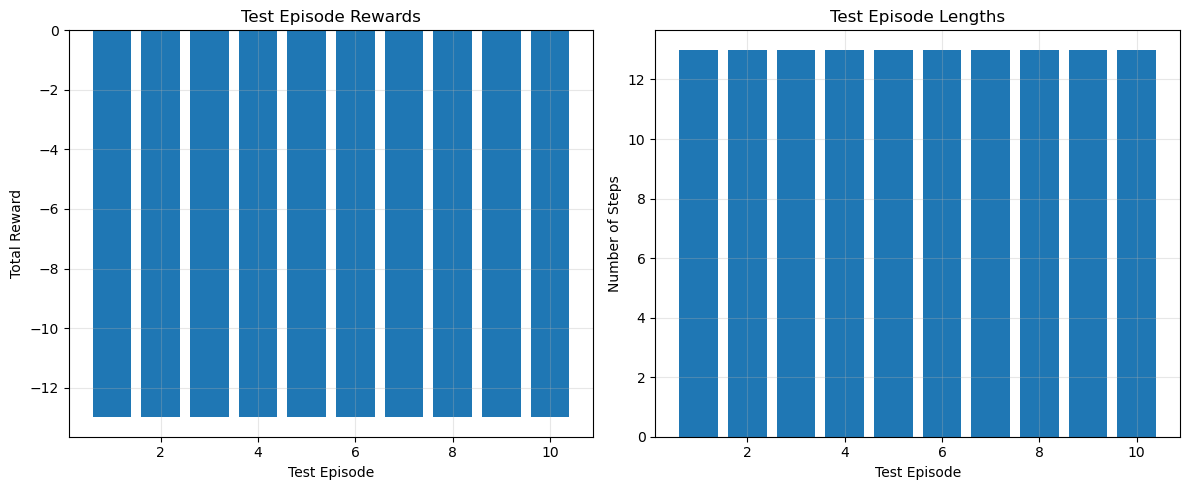


Q-Learning Algorithm Summary:
• Environment: CliffWalk-v0
• Training episodes: 1000
• Final success rate: 100.0%
• Average test reward: -13.00
• Average test episode length: 13.0 steps

Demonstrating optimal path:
Starting at state 36
Step 1: Action = UP, New State = 24, Reward = -1
Step 2: Action = RIGHT, New State = 25, Reward = -1
Step 3: Action = RIGHT, New State = 26, Reward = -1
Step 4: Action = RIGHT, New State = 27, Reward = -1
Step 5: Action = RIGHT, New State = 28, Reward = -1
Step 6: Action = RIGHT, New State = 29, Reward = -1
Step 7: Action = RIGHT, New State = 30, Reward = -1
Step 8: Action = RIGHT, New State = 31, Reward = -1
Step 9: Action = RIGHT, New State = 32, Reward = -1
Step 10: Action = RIGHT, New State = 33, Reward = -1
Step 11: Action = RIGHT, New State = 34, Reward = -1
Step 12: Action = RIGHT, New State = 35, Reward = -1
Step 13: Action = DOWN, New State = 47, Reward = -1

Optimal path found in 13 steps with total reward: -13
Path taken: 36 → 24 → 25 → 26 → 2

In [6]:
# Test the trained agent
test_results = agent.test(env, n_episodes=10, render=False)

print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

# Visualize test results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Test rewards
axes[0].bar(range(1, len(test_results['test_rewards']) + 1), test_results['test_rewards'])
axes[0].set_title('Test Episode Rewards')
axes[0].set_xlabel('Test Episode')
axes[0].set_ylabel('Total Reward')
axes[0].grid(True, alpha=0.3)

# Test episode lengths
axes[1].bar(range(1, len(test_results['test_lengths']) + 1), test_results['test_lengths'])
axes[1].set_title('Test Episode Lengths')
axes[1].set_xlabel('Test Episode')
axes[1].set_ylabel('Number of Steps')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of learning
print(f"\nQ-Learning Algorithm Summary:")
print(f"• Environment: CliffWalk-v0")
print(f"• Training episodes: {len(agent.episode_rewards)}")
print(f"• Final success rate: {test_results['success_rate']:.1%}")
print(f"• Average test reward: {np.mean(test_results['test_rewards']):.2f}")
print(f"• Average test episode length: {np.mean(test_results['test_lengths']):.1f} steps")

# Demonstrate optimal path
print(f"\nDemonstrating optimal path:")
state, _ = env.reset()
path = [state]
total_reward = 0
steps = 0

print(f"Starting at state {state}")
while steps < 50:  # Safety limit
    action = agent.get_action(state, training=False)
    next_state, reward, terminated, truncated, _ = env.step(action)
    
    action_name = ['UP', 'RIGHT', 'DOWN', 'LEFT'][action]
    print(f"Step {steps + 1}: Action = {action_name}, New State = {next_state}, Reward = {reward}")
    
    path.append(next_state)
    total_reward += reward
    steps += 1
    
    if terminated or truncated:
        break
    
    state = next_state

print(f"\nOptimal path found in {steps} steps with total reward: {total_reward}")
print(f"Path taken: {' → '.join(map(str, path))}")

env.close()